In [1]:
import db_utils_new as db

In [2]:
# Setting up connection, creating engine and inspecting the data

connector_1 = db.RDSDatabaseConnector(db.credentials_to_dict())
engine_1 = connector_1.init_sql_engine()
extractor_1 = db.Extractor()
loan_payments = extractor_1.get_table_as_df(engine=engine_1, table='loan_payments')


In [3]:
# Checking null percentages and dropping every column over 50% missing

dfinfo_1 = db.DataFrameInfo()
dfinfo_1.check_null_percentages(loan_payments)


id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term                            8.799395
int_rate                        9.531449
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
employment_length               3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_record         88.602460
open_accounts   

In [4]:
# Drop all columns where null percentage > 50%

dftransform_1= db.DataFrameTransform()
dftransform_1.drop_column(loan_payments, 'mths_since_last_delinq')
dftransform_1.drop_column(loan_payments, 'mths_since_last_record')
dftransform_1.drop_column(loan_payments, 'next_payment_date')
dftransform_1.drop_column(loan_payments, 'mths_since_last_major_derog')


In [5]:
# Look at other nulls to be addressed
dfinfo_1=db.DataFrameInfo()
dfinfo_1.check_no_of_nulls(loan_payments)

id                               0
member_id                        0
loan_amount                      0
funded_amount                 3007
funded_amount_inv                0
term                          4772
int_rate                      5169
instalment                       0
grade                            0
sub_grade                        0
employment_length             2118
home_ownership                   0
annual_inc                       0
verification_status              0
issue_date                       0
loan_status                      0
payment_plan                     0
purpose                          0
dti                              0
delinq_2yrs                      0
earliest_credit_line             0
inq_last_6mths                   0
open_accounts                    0
total_accounts                   0
out_prncp                        0
out_prncp_inv                    0
total_payment                    0
total_payment_inv                0
total_rec_prncp     

In [16]:
# Let's check the MCAR assumption for each of these nulls. 
import plotly.express as px

null_sums = loan_payments.isna().sum()

with_nulls = null_sums[null_sums > 0]

cols_with_nulls_ls = list(with_nulls.keys())

null_testing_df = loan_payments.copy()

for col in cols_with_nulls_ls:
    null_testing_df[f'{col}_nulls'] = loan_payments[col].isna()

px.imshow(null_testing_df.corr(numeric_only=True), title="Correlation heatmap for checking MCAR of nulls")

Plot for funded_amount
Plot for term


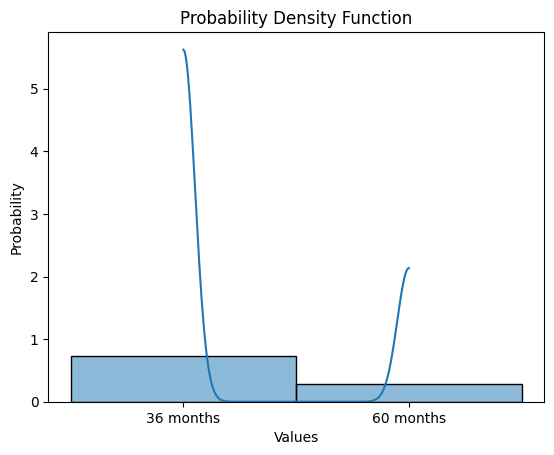

The mode of the distribution is 36 months
Plot for int_rate


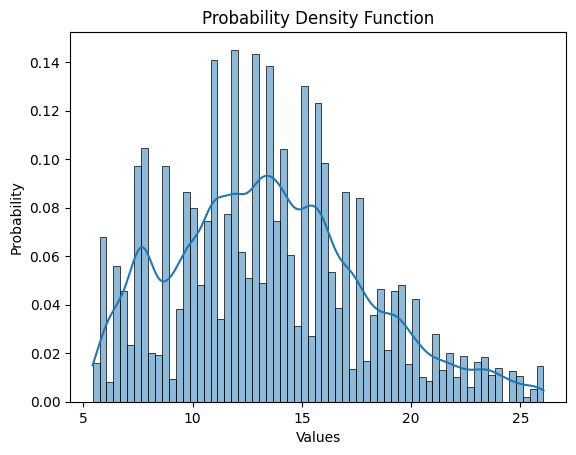

The mode of the distribution is 11.99
The mean of the distribution is 13.507328482328484
The median of the distribution is 13.16
Plot for employment_length


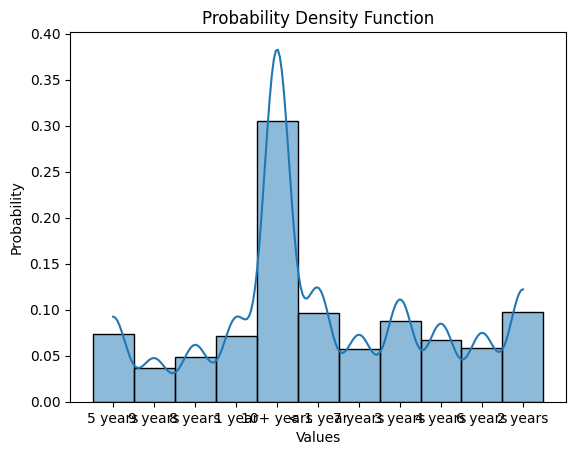

The mode of the distribution is 10+ years
Plot for last_payment_date


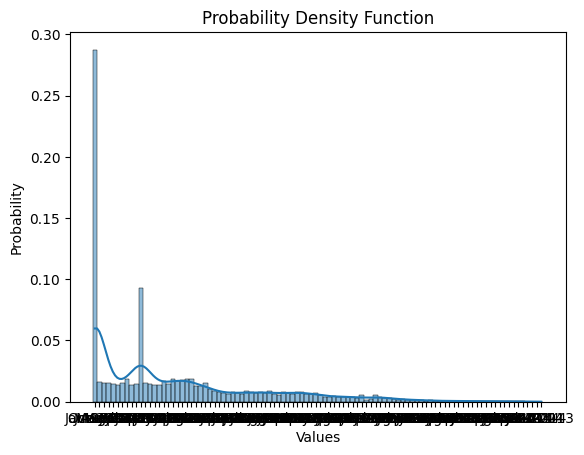

The mode of the distribution is Jan-2022
Plot for last_credit_pull_date


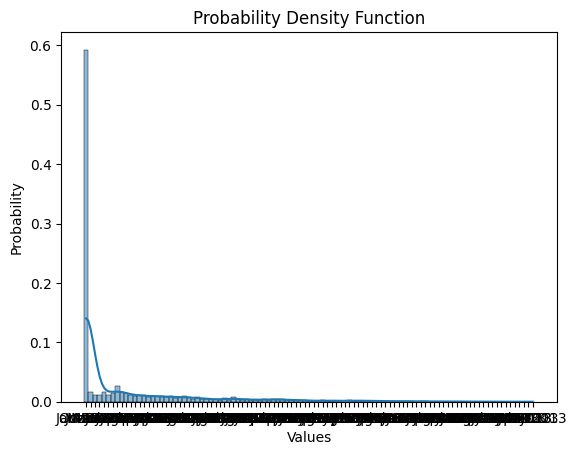

The mode of the distribution is Jan-2022
Plot for collections_12_mths_ex_med


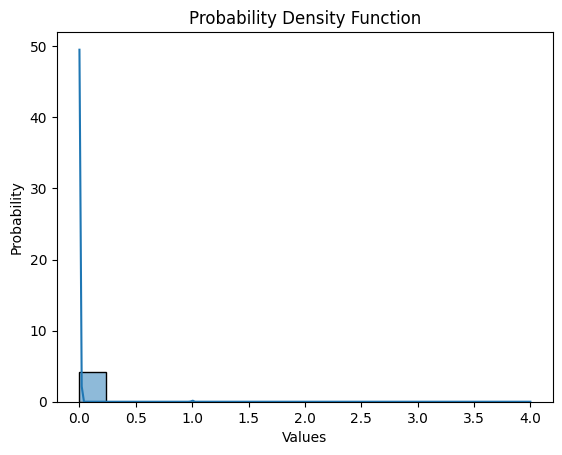

The mode of the distribution is 0.0
The mean of the distribution is 0.004208194905869324
The median of the distribution is 0.0


In [18]:
# We can see from this graphic that MCAR holds for all the nulls. Now we need to decide how to compute. Let's look at rhe distributions of the columns
plotter_1=db.Plotter()

for col in cols_with_nulls_ls:
    try:
        print(f'Plot for {col}')
        plotter_1.PDF_plot_with_averages(loan_payments, col)
    except:
        pass
        


In [19]:
# From this I can make some imputation decisisons.

dftransform_1 = db.DataFrameTransform()

dftransform_1.impute_mode(loan_payments, 'collections_12_mths_ex_med')
dftransform_1.impute_mode(loan_payments, 'last_credit_pull_date')
dftransform_1.impute_mode(loan_payments, 'last_payment_date')
dftransform_1.impute_mode(loan_payments, 'employment_length')
dftransform_1.impute_median(loan_payments, 'int_rate')
dftransform_1.impute_mode(loan_payments, 'term')


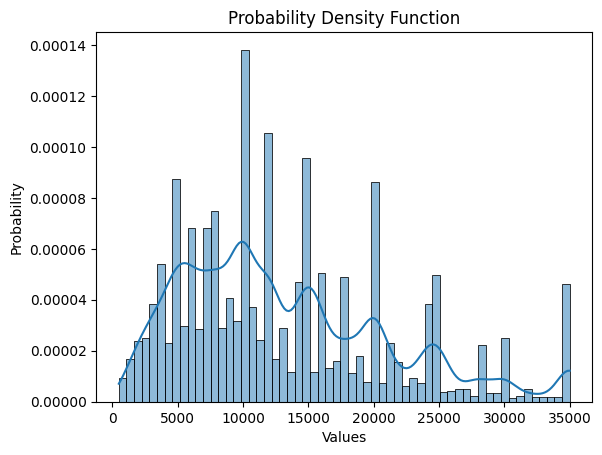

The mode of the distribution is 10000.0
The mean of the distribution is 13229.50911682024
The median of the distribution is 12000.0


In [24]:
# Last column to address because it didnt plot successfully, and impute!

plotter_1.PDF_plot_with_averages(loan_payments, 'funded_amount')
dftransform_1.impute_median(loan_payments, 'funded_amount')

In [26]:
# Changing all the datestring cols to iso format

datestring_cols = ['issue_date','earliest_credit_line','last_payment_date', 'last_credit_pull_date']
datatransformer_1 = db.DataTransform()
for column in datestring_cols:
    datatransformer_1.convert_datestrings_to_iso(loan_payments, column)


In [29]:
# Converting 'term' column to number of months
datatransformer_1= db.DataTransform()
# Need to first address nulls by imputing the mode
datatransformer_1.convert_monthstrings_to_float64(loan_payments, 'term')

In [31]:
# Converting 'employment_length' column into float64 object
datatransformer_1=db.DataTransform()
datatransformer_1.convert_yearstrings_to_float64_2(loan_payments, 'employment_length')


In [32]:
#%% Saving downloaded dataframe locally
csv_df_1 = db.CSV_DF()
csv_df_1.save_as_csv(loan_payments, 'loan_payments.csv')

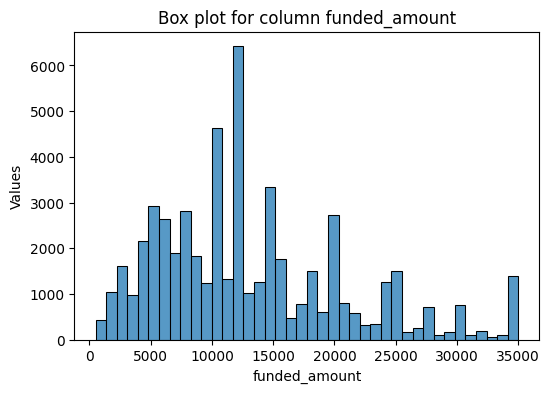

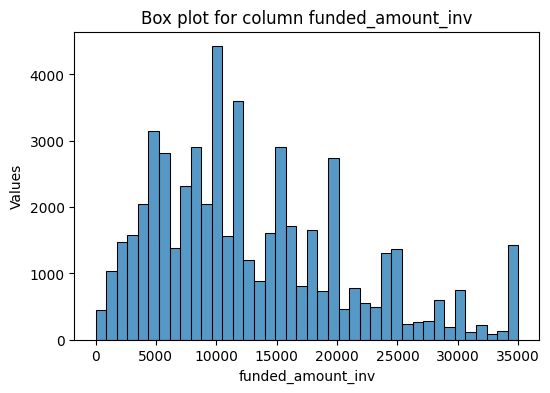

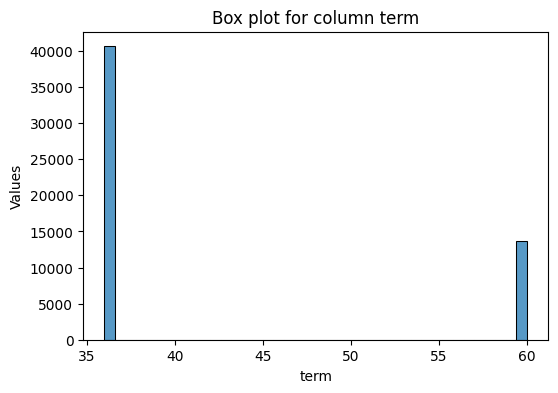

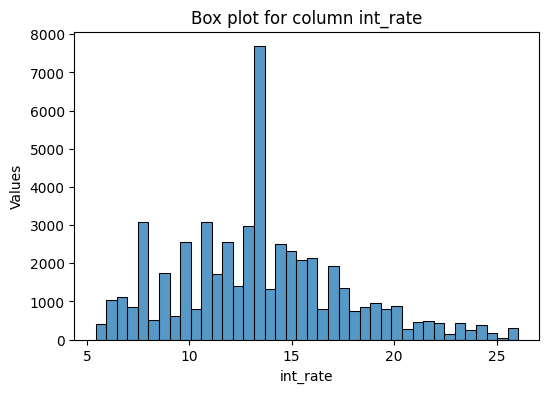

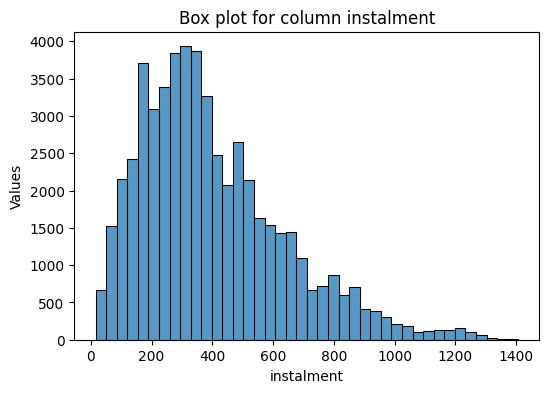

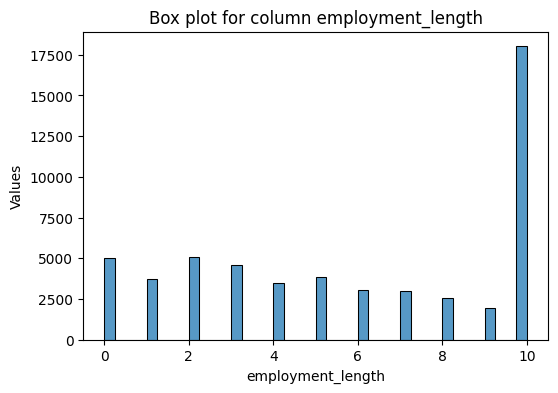

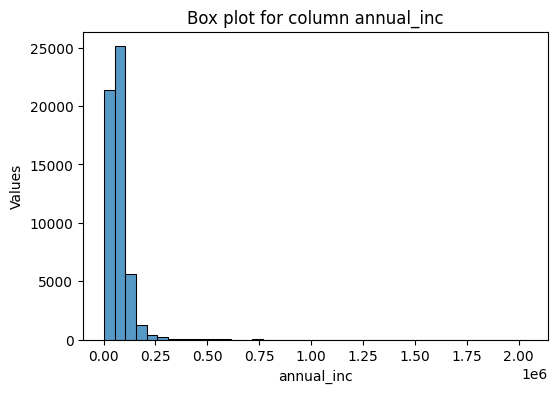

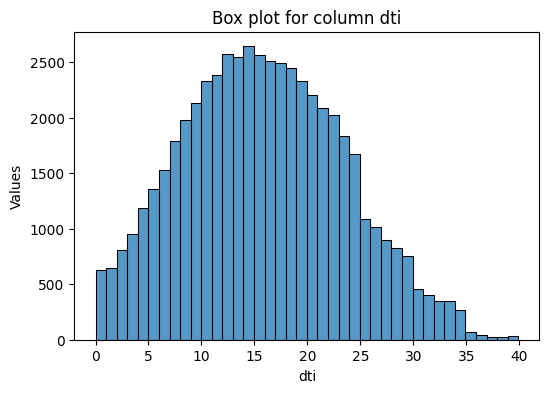

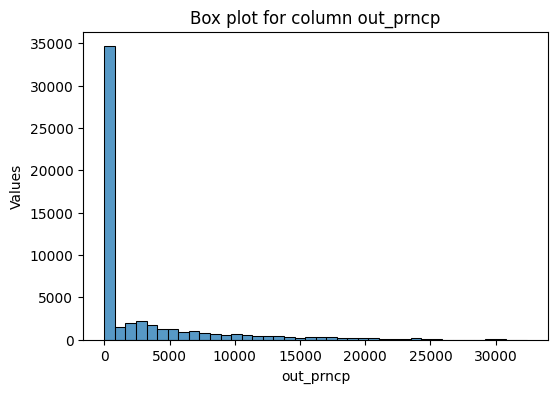

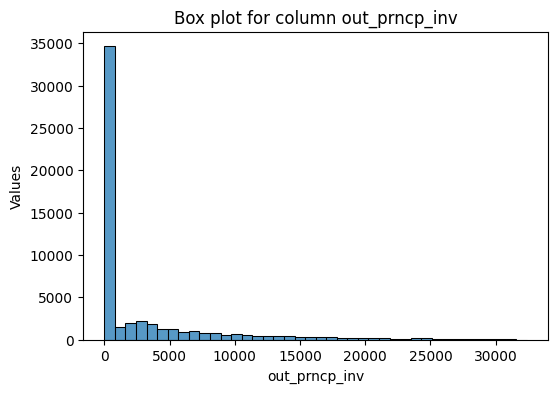

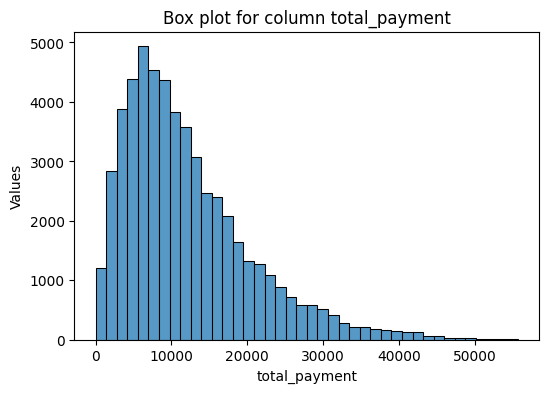

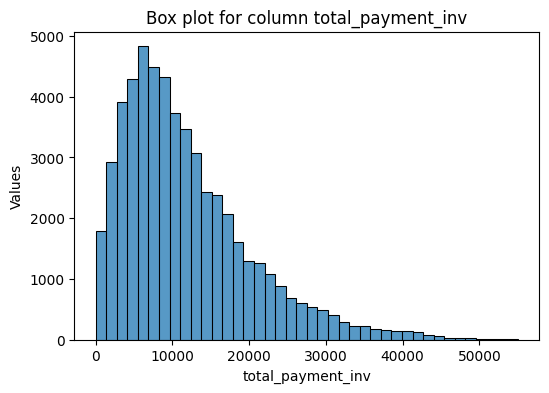

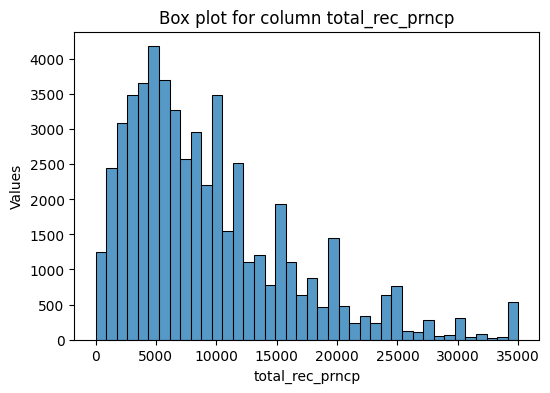

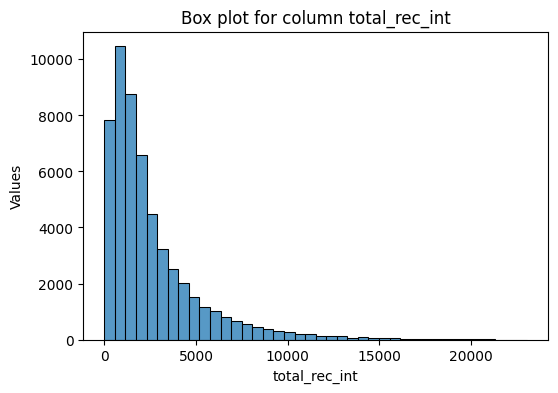

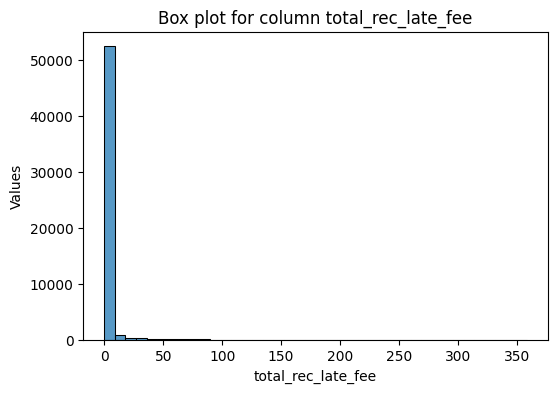

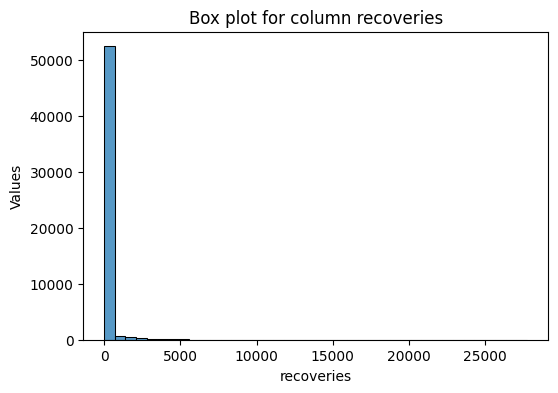

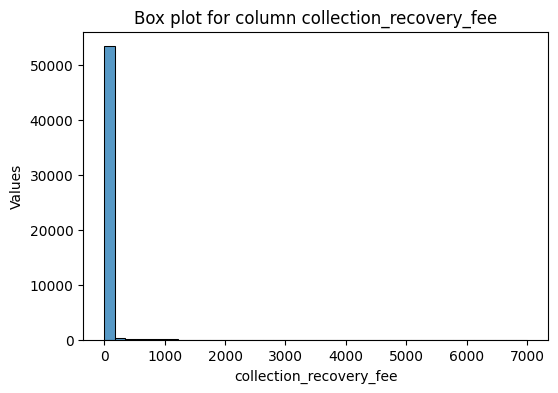

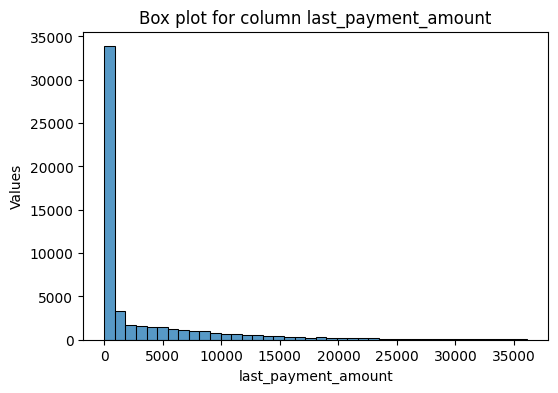

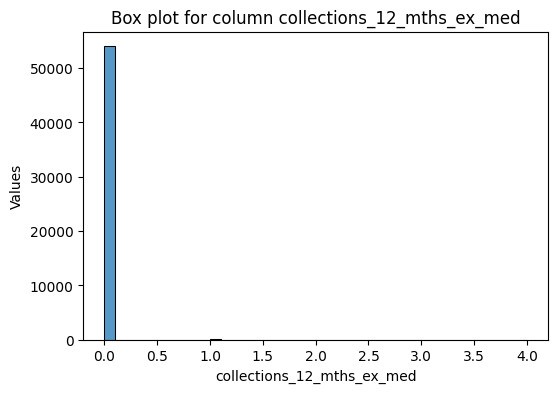

In [33]:
#  Histplots for all cols of dtype 'float64' to do visual inspection, looking for skew
plotter_1 = db.Plotter()
plotter_1.histplot_all_float_cols(loan_payments)

In [34]:
# Identifying which numeric columns are skewed and correcting skew using a Yeo-Johson transformation
dfinfo_1 = db.DataFrameInfo()
dftransform_1 = db.DataFrameTransform()
skewed_data = dfinfo_1.get_skews(loan_payments)

for i in range(0, len(skewed_data)-1):
    dftransform_1.yeojohnson_transformation(loan_payments, str(skewed_data[i]))
# Could in theory make this bit of code a method of DataTransformer class - ??

Skew of id: 2.370336021094686
Skew of member_id: 2.205422084785879
Skew of loan_amount: 0.8052592257800115
Skew of funded_amount: 0.8699218016852919
Skew of funded_amount_inv: 0.8139274222318484
Skew of term: 1.1483578259299072
Skew of int_rate: 0.45651514244548674
Skew of instalment: 0.9969813991920319
Skew of employment_length: -0.1830194747186552
Skew of annual_inc: 8.711831033809583
Skew of dti: 0.18941964982496076
Skew of delinq_2yrs: 5.370001885877136
Skew of inq_last_6mths: 3.248918364007299
Skew of open_accounts: 1.0592820053165104
Skew of total_accounts: 0.7790139244121327
Skew of out_prncp: 2.356426188671512
Skew of out_prncp_inv: 2.3568475131007687
Skew of total_payment: 1.267890957776937
Skew of total_payment_inv: 1.256196603509513
Skew of total_rec_prncp: 1.2610146774673532
Skew of total_rec_int: 2.204322035306792
Skew of total_rec_late_fee: 13.184304523859357
Skew of recoveries: 14.58979334668037
Skew of collection_recovery_fee: 27.63684310809756
Skew of last_payment_amou

In [37]:
# Observe correlation heatmap to look for colinearities
import plotly.express as px
dfinfo_1=db.DataFrameInfo()
px.imshow(loan_payments.corr(numeric_only=True), title="Correlation heatmap of student dataframe")

In [36]:
# If column correlation > 0.9 drop one of them
dftransform_1 = db.DataFrameTransform()
dftransform_1.drop_column(loan_payments, 'funded_amount_inv')
dftransform_1.drop_column(loan_payments, 'out_prncp_inv')
dftransform_1.drop_column(loan_payments, 'total_payment_inv')
dftransform_1.drop_column(loan_payments, 'total_rec_prncp')
dftransform_1.drop_column(loan_payments, 'funded_amount')
dftransform_1.drop_column(loan_payments, 'collection_recovery_fee')


In [38]:
# Observe again to check the colinearities have gone!

import plotly.express as px
dfinfo_1=db.DataFrameInfo()
px.imshow(loan_payments.corr(numeric_only=True), title="Correlation heatmap of student dataframe")